## Описание колонок в дата-фрейме:

| Название колонки       | Описание                                           |
|-----------------------|----------------------------------------------------|
| id                    | Уникальный ID записи                               |
| date_created          | Дата и время создания заказа                        |
| order_id              | Уникальный ID заказа                                |
| city_name             | Город заказа                                       |
| date_assembly_started | Дата и время начала сборки заказа                   |
| work_place_id         | ID места работника, который работает с заказом      |
| date_picked           | Дата и время окончания отбора позиций заказа       |
| single_item           | Булевое значение: находится ли в заказе 1 товар в количестве 1 штука |
| from_multi_stock_wave | Булевое значение: собирается ли заказ с нескольких складов |

### Задачи
1) Получить среднее время от создания заказа до начала сборки; среднее время от начала сборки заказа до окончания отбора позиций.
2) Для пункта выше - посчитать индекс аффинитивности.
3) Посмотреть динамику кол-ва заказов по городам и общую динамику и ответить на вопрос: какие города развиваются более динамично - предложить возможные причины динамики.
4) Проверить гипотезу: связана ли загруженность склада (кол-во созданных заказов) со временем сборки заказа?
5) Сегментировать города по произвольному кол-ву количественных признаков: обосновать логику сегментации и предложить модели работы с каждым сегментом.

### Сводная таблица по датасету

In [147]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# настройки для вывода графиков
sns.set(rc={'figure.figsize': (16,6),'figure.dpi': (70)},style='darkgrid')

#чтение csv
df = pd.read_csv('Step_1_Uzum_Academy.csv', parse_dates=['date_created','date_assembly_started','date_picked'])
df = df.drop(['Unnamed: 0','dp_id'], axis = 1)
df = df.dropna()

# разделяем колонку city_name на 3 колонки city_name_ru city_name_uz place
df[['map','place']] = df['city_name'].apply(lambda x: pd.Series(str(x).split("} ")))
df['map'] = df['map'].apply(lambda x: x + '}')
import json

# преобразуем в обьект python
def try_parse_json(x):
    try:
        return json.loads(x)
    except json.JSONDecodeError:
        return {}

df['map'] = df['map'].apply(try_parse_json)
# вытаскиваем значения из словаря
df['city_name_ru'] = df['map'].apply(lambda x: x.get('ru', ''))
df['city_name_uz'] = df['map'].apply(lambda x: x.get('uz', ''))

# удаляем лишнее
df = df.drop(['map','city_name'],axis = 1)
df.dropna(inplace=True)

# переименовываем
df.rename(columns={"date_assembly_started": "date_picked",
                   "date_picked": "date_assembly_started"})

# меняем местами в таблице(для удобства)
df['date_assembly_started'], df['date_picked'] = df['date_picked'] , df['date_assembly_started']

# сводная таблица
lst = []
for name in df.columns:
    
    # выводим название, уникальные и пропущенные значения
    nu = len(df[name].unique())
    nisnan = df[name].isnull().sum()
    values_sample = df[name].unique()[:min(nu, 10)].tolist()
    
    # выводим мин и макс для всех кроме строковых
    min_val = df[name].min() if not pd.api.types.is_object_dtype(df[name]) else None
    max_val = df[name].max() if not pd.api.types.is_object_dtype(df[name]) else None
    
    # формируем таблицу
    lst.append([name, nu, nisnan, values_sample, min_val, max_val])
    
# даем название колонкам
table = pd.DataFrame(lst, columns=['column', 'nunique', 'nnull', 'values', 'min', 'max'])
table['data_types'] = df.dtypes.values
table

,column,nunique,nnull,values,min,max,data_types
0,id,2452,0,"[131199.09910894395, 65635.22394167945, 47216....",1289.944564,160020.509856,float64
1,date_created,2452,0,"[2023-10-03 14:15:30.183690, 2023-07-02 13:34:...",2022-10-22 15:15:03.031786,2023-11-01 12:03:27.277225,datetime64[ns]
2,order_id,2452,0,"[154445.14897803558, 77009.7864098282, 54323.2...",246.000291,186525.393724,float64
3,date_assembly_started,2452,0,"[2023-10-03 15:51:56.474616, 2023-07-02 15:03:...",2022-10-22 15:22:49.492786,2023-11-01 14:27:57.064675,datetime64[ns]
4,work_place_id,46,0,"[123.0, 107.0, 109.0, 128.0, 101.0, 102.0, 126...",3.0,500.0,float64
5,date_picked,2452,0,"[2023-10-03 16:17:51.777480, 2023-07-02 15:38:...",2022-10-22 15:57:53.488088,2023-11-01 16:36:52.753178,datetime64[ns]
6,single_item,2,0,"[False, True]",False,True,bool
7,from_multi_stock_wave,1,0,[False],False,False,bool
8,place,257,0,"[Kuryerlik xizmati, ТАШ-25, ТАШ-41, ШРЗ-1, МРГ...",None,None,object
9,city_name_ru,65,0,"[Бухара, Ташкент, Шахрисабз, Маргилан, Карши, ...",None,None,object


### 1. таблица (count_df) со средним(assembly_start_delay, assembly_duration) временем колонок выраженный в секундах

In [148]:
# создаем новые признаки,длительности этапов
df['assembly_start_delay'] = df['date_assembly_started'] - df['date_created']
df['assembly_duration'] = df['date_picked'] - df['date_assembly_started']
df['full_time'] = df['date_picked'] - df['date_created']

# переводим в секунд
df['assembly_start_delay'] = df['assembly_start_delay'].dt.total_seconds()
df['assembly_duration'] = df['assembly_duration'].dt.total_seconds()
df['full_time'] = df['full_time'].dt.total_seconds()

# переводим в дату
df['date_created'] = pd.to_datetime(df['date_created']).dt.date

# группируем датафрейм по интересующимся нам признакам
count_df = (df.groupby(['date_created','city_name_ru'],as_index=False)
      .agg({'assembly_start_delay': 'mean',
            'assembly_duration':    'mean',
            'full_time':            'mean',
            'order_id':             'count',
            'work_place_id':        'count'}))
count_df.head()

,date_created,city_name_ru,assembly_start_delay,assembly_duration,full_time,order_id,work_place_id
0,2022-10-22,Ташкент,466.461000,2103.995302,2570.456302,1,1
1,2022-10-23,Ташкент,4566.814633,2860.122836,7426.937469,1,1
2,2022-10-24,Ташкент,10232.673719,9967.116237,20199.789956,1,1
3,2022-10-27,Ташкент,26580.453358,4727.415495,31307.868853,1,1
4,2022-11-02,Ташкент,6720.487769,3328.047716,10048.535485,1,1


#### Смотрим на выбросы временного ряда

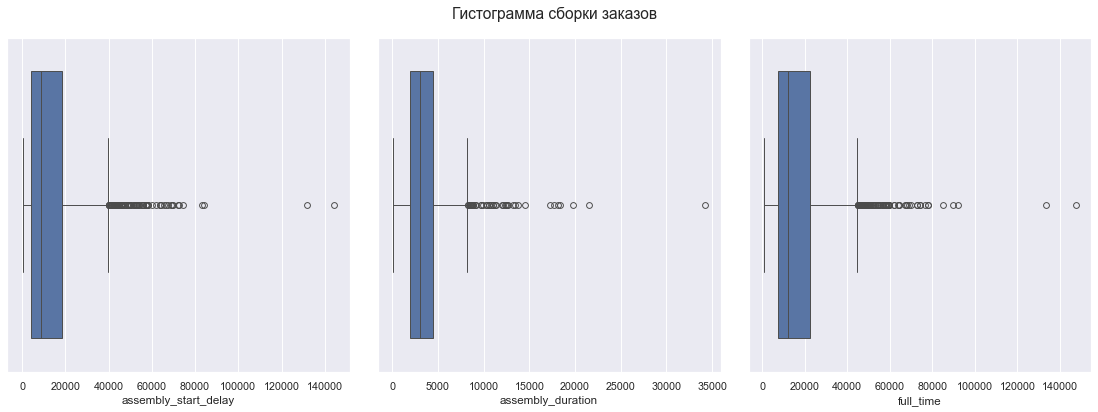

In [149]:
plt.suptitle('Гистограмма сборки заказов', fontsize=16)

for i, col in enumerate(count_df[['assembly_start_delay','assembly_duration','full_time']], start=1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=count_df, x = col)
plt.tight_layout()
plt.show()

#### Распределение не выглядит нормальным у временных рядов

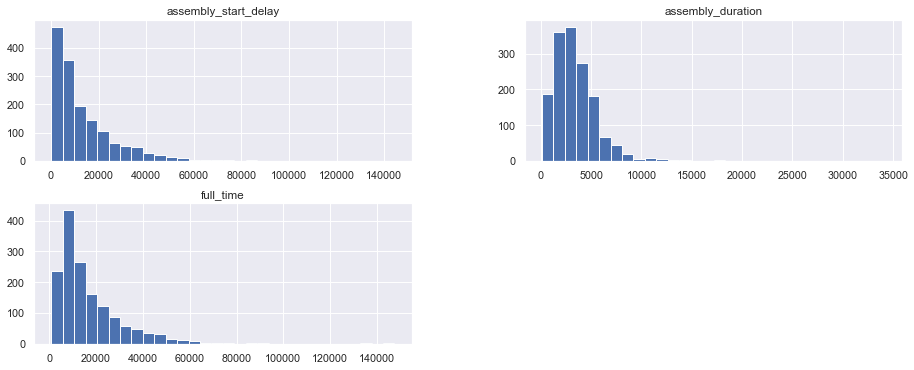

In [150]:
count_df[['assembly_start_delay','assembly_duration','full_time']].hist(bins=30);

### 2. Предобработка и создание новой таблицы mean_df(новые колонки: индекс аффенитивности, рейтинг по квантилям временных рядов)

In [151]:
# избавляемся от выбросов
count_df.loc[count_df['assembly_start_delay'] > 80000, 'assembly_start_delay'] = count_df['assembly_start_delay'].mean()
count_df.loc[count_df['assembly_duration'] > 15000, 'assembly_duration'] = count_df['assembly_duration'].mean()
count_df.loc[count_df['full_time'] > 80000, 'full_time'] = count_df['full_time'].mean()

count_df.loc[count_df['assembly_start_delay'] <  count_df['assembly_start_delay'].quantile(0.20), 'assembly_start_delay'] = count_df['assembly_start_delay'].mean()
count_df.loc[count_df['assembly_duration'] <     count_df['assembly_duration'].quantile(0.20), 'assembly_duration'] = count_df['assembly_duration'].mean()
count_df.loc[count_df['full_time'] <             count_df['full_time'].quantile(0.20), 'full_time'] = count_df['full_time'].mean()

# Группировка по городам и подсчет средних значений для заданных столбцов
mean_df = (pd.pivot_table(data=df, 
                          index=['city_name_ru'], 
                          values=['assembly_start_delay', 'assembly_duration', 'full_time','order_id'], 
                          aggfunc={'assembly_start_delay': 'mean', 'assembly_duration': 'mean', 'full_time': 'mean','order_id':'count'})
              .rename(columns={'order_id':'count_order_id'})
              .reset_index())

mean_df.rename(columns={'assembly_start_delay': 'assembly_start_delay_mean',
                        'assembly_duration': 'assembly_duration_mean',
                        'full_time': 'full_time_mean'}, inplace=True)

mean_df['assembly_duration_mean'] = mean_df['assembly_duration_mean'].round(0)
mean_df['assembly_start_delay_mean'] = mean_df['assembly_start_delay_mean'].round(0)
mean_df['full_time_mean'] = mean_df['full_time_mean'].round(0).astype('int32')
# Расчет AFF (Adjusted Factor of Frequency) для assembly_start_delay
mean_df['AFF_delay'] = mean_df['assembly_start_delay_mean'] / mean_df['assembly_start_delay_mean'].mean().round(2)

# Расчет AFF для assembly_duration
mean_df['AFF_duration'] = mean_df['assembly_duration_mean'] / mean_df['assembly_duration_mean'].mean().round(2)

# Расчет AFF для full_time
mean_df['AFF_full_time'] = mean_df['full_time_mean'] / mean_df['full_time_mean'].mean().round(2)

# Разделение городов на квантили (первый, второй, третий)
mean_df['assembly_start_delay_q'] = np.where(
    mean_df['assembly_start_delay_mean'] < mean_df['assembly_start_delay_mean'].quantile(0.33), 'first',
    np.where(
        (mean_df['assembly_start_delay_mean'] < mean_df['assembly_start_delay_mean'].quantile(0.66)) & 
        (mean_df['assembly_start_delay_mean'] > mean_df['assembly_start_delay_mean'].quantile(0.33)), 'second', 'third'))

mean_df['assembly_duration_q'] = np.where(
    mean_df['assembly_duration_mean'] < mean_df['assembly_duration_mean'].quantile(0.33), 'first',
    np.where(
        (mean_df['assembly_duration_mean'] < mean_df['assembly_duration_mean'].quantile(0.66)) & 
        (mean_df['assembly_duration_mean'] > mean_df['assembly_duration_mean'].quantile(0.33)), 'second', 'third'))

mean_df['full_time_q'] = np.where(
    mean_df['full_time_mean'] < mean_df['full_time_mean'].quantile(0.33), 'first',
    np.where(
        (mean_df['full_time_mean'] < mean_df['full_time_mean'].quantile(0.66)) & 
        (mean_df['full_time_mean'] > mean_df['full_time_mean'].quantile(0.33)), 'second', 'third'))

# Формирование финальной группировки по квантилям
mean_df['quanitle_rate'] = mean_df['assembly_start_delay_q'] + '_' + mean_df['assembly_duration_q'] + '_' + mean_df['full_time_q']
mean_df.head()

,city_name_ru,assembly_duration_mean,assembly_start_delay_mean,full_time_mean,count_order_id,AFF_delay,AFF_duration,AFF_full_time,assembly_start_delay_q,assembly_duration_q,full_time_q,quanitle_rate
0,Аккурган,2728.0,11187.0,13916,6,0.949122,0.753185,0.903130,second,first,second,second_first_second
1,Алмазар,5626.0,24662.0,30288,3,2.092362,1.553307,1.965652,third,third,third,third_third_third
2,Алмалык,4364.0,16596.0,20959,48,1.408030,1.204876,1.360212,third,third,third,third_third_third
3,Ангрен,3573.0,10086.0,13659,24,0.855712,0.986485,0.886451,second,second,second,second_second_second
4,Андижан,3302.0,12388.0,15691,83,1.051017,0.911664,1.018325,third,second,second,third_second_second


##### Создание новой таблицы avg_df:

- группируем по рейтингу квантилей, 
- создание новых колонок: 
    - аггрегация по среднему 
    - std для временных рядов
- Присутствуют NaN значения так как в quantile_rate встречаются лишь одно значение и невозможно вычислить стандартное отклонение

In [152]:
avg_df = mean_df.groupby('quanitle_rate').agg({
    'assembly_start_delay_mean': ['mean', 'std'],
    'assembly_duration_mean': ['mean', 'std'],
    'full_time_mean': ['mean', 'std']
}).reset_index()

# Для удобства переименуем столбцы
avg_df.columns = ['quanitle_rate', 'avg_assembly_start_delay', 'std_assembly_start_delay',
                   'avg_assembly_duration', 'std_assembly_duration',
                   'avg_full_time', 'std_full_time']
# Замена NaN на 0
avg_df.fillna(0, inplace=True)

# Преобразование к типу int32
avg_df[['avg_assembly_start_delay', 'std_assembly_start_delay',
        'avg_assembly_duration', 'std_assembly_duration',
        'avg_full_time', 'std_full_time']] = avg_df[['avg_assembly_start_delay', 'std_assembly_start_delay',
                                                     'avg_assembly_duration', 'std_assembly_duration',
                                                     'avg_full_time', 'std_full_time']].round(0).astype('int32')

avg_df.head(5)


,quanitle_rate,avg_assembly_start_delay,std_assembly_start_delay,avg_assembly_duration,std_assembly_duration,avg_full_time,std_full_time
0,first_first_first,5096,2164,2256,792,7352,2194
1,first_second_first,6952,999,3392,143,10344,969
2,first_third_first,5825,2641,4207,408,10031,2347
3,first_third_second,8393,0,3995,0,12388,0
4,second_first_first,8577,0,3016,0,11594,0


##### образовываются нули потому std для выборки где количество = 1 невозможно определить

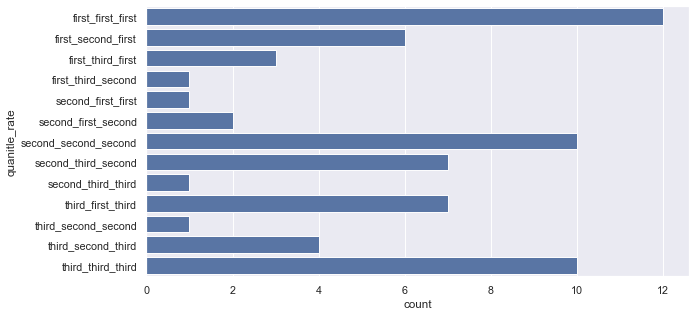

In [153]:
plt.figure(figsize=(10,5),dpi=70)
sns.countplot(mean_df['quanitle_rate'].sort_values());

### 3. Посмотреть динамику кол-ва заказов по городам и общую динамику и ответить на вопрос: какие города развиваются более динамично - предложить возможные причины динамики.

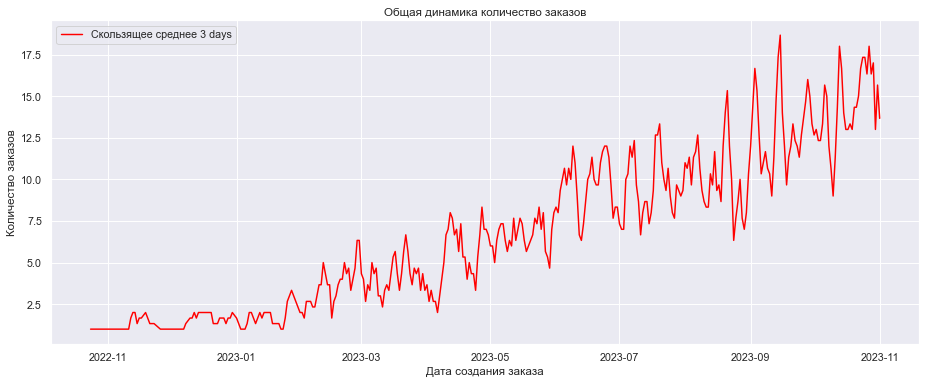

In [154]:
total_orders_by_date = df.groupby('date_created').size().reset_index(name='total_order_count')
# Вычисление скользящего среднего для общей динамики
total_orders_by_date['avg_rolling_window_3'] = total_orders_by_date['total_order_count'].rolling(window=3).mean()

# Построение графика общей динамики с использованием скользящего среднего
plt.plot(total_orders_by_date['date_created'], total_orders_by_date['avg_rolling_window_3'], color='red', label='Скользящее среднее 3 days')
plt.title('Общая динамика количество заказов')
plt.xlabel('Дата создания заказа')
plt.ylabel('Количество заказов')
plt.legend();


##### Ташкент не трогал, Ташкент растет.

первая четверка городов по количеству заказов(после Ташкента)

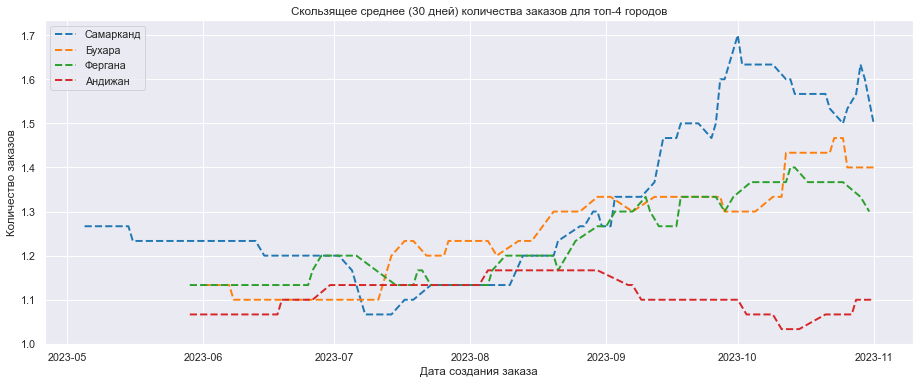

In [155]:
# Группировка по городам и подсчет количества заказов
orders_by_city = df.groupby('city_name_ru').size().reset_index(name='total_orders')
orders_by_city_date = df.groupby(['date_created', 'city_name_ru']).size().reset_index(name='order_count')

# Выбор топ-4 городов по количеству заказов
top_cities = orders_by_city.nlargest(10, 'total_orders')['city_name_ru'].tolist()[1:5]

# Отбор данных только для топ-4 городов
top_orders = orders_by_city_date[orders_by_city_date['city_name_ru'].isin(top_cities)]

palette = sns.color_palette('tab10')
for i, city in enumerate(top_cities):
    city_data = top_orders[top_orders['city_name_ru'] == city]
    smoothed_orders = city_data['order_count'].rolling(window=30).mean()
    plt.plot(city_data['date_created'], smoothed_orders, label=f'{city}', linewidth=2, linestyle='--', color=palette[i])

plt.title('Скользящее среднее (30 дней) количества заказов для топ-4 городов')
plt.xlabel('Дата создания заказа')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()


In [156]:
mean_df[mean_df['city_name_ru'].isin(top_cities)][['city_name_ru','AFF_delay','AFF_duration','AFF_full_time','quanitle_rate']].sort_values(by='AFF_full_time')

,city_name_ru,AFF_delay,AFF_duration,AFF_full_time,quanitle_rate
46,Самарканд,0.696125,0.879361,0.739196,first_second_first
52,Фергана,0.865723,0.993940,0.895862,second_second_second
9,Бухара,0.889479,0.933475,0.899756,second_second_second
4,Андижан,1.051017,0.911664,1.018325,third_second_second


#### Вывод по графику:
- По индексам Фергана показывает лучше показатели аффенитивности чем Бухара, но уступает по количеству заказов.(думаю дело во внешних признаках, например платежоспособность региона)
- Андижан показывает хуже результаты чем остальные, 
    - по индексам он проигрывает, 
    - разница в индексах не большая с остальными, 
    - на графикеон придерживается значения 1.1 (не растет)
    - видимо из за раннего старта он в топе

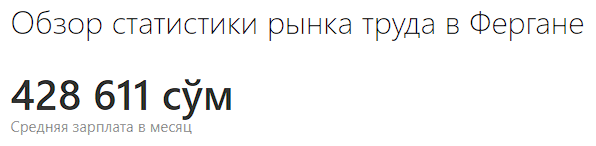
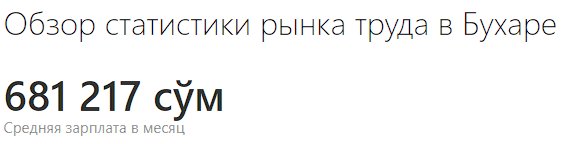

данные взяты из: https://uz.trud.com

Вторая четверка городов по количеству заказов(после Ташкента)

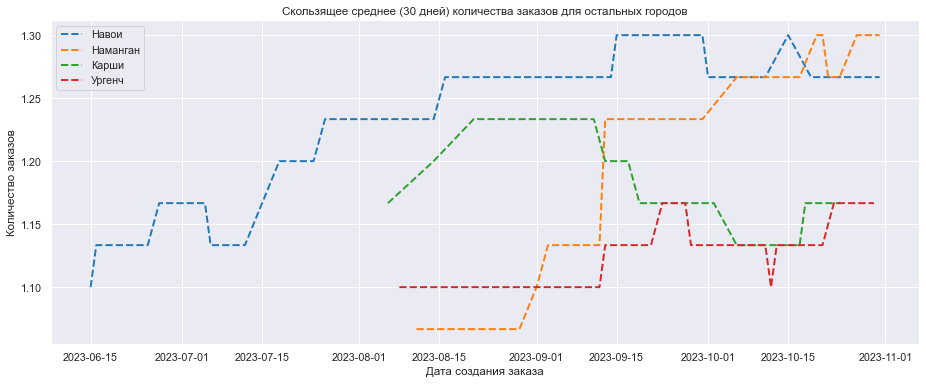

In [157]:
top_cities_2 = orders_by_city.nlargest(10, 'total_orders')['city_name_ru'].tolist()[5:9]

# Отбор данных только для топ-4 городов
top_orders = orders_by_city_date[orders_by_city_date['city_name_ru'].isin(top_cities_2)]

# Сглаживание данных скользящим средним для каждого города
# ... (ваш предыдущий код)

# Сглаживание данных скользящим средним для каждого города с различными цветами
palette = sns.color_palette('tab10')  # Выбираем палитру цветов
for i, city in enumerate(top_cities_2):
    city_data = top_orders[top_orders['city_name_ru'] == city]
    smoothed_orders = city_data['order_count'].rolling(window=30).mean()
    plt.plot(city_data['date_created'], smoothed_orders, label=f'{city}', linewidth=2, linestyle='--', color=palette[i])

plt.title('Скользящее среднее (30 дней) количества заказов для остальных городов')
plt.xlabel('Дата создания заказа')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

In [158]:
mean_df[mean_df['city_name_ru'].isin(top_cities_2)][['city_name_ru','AFF_delay','AFF_duration','AFF_full_time','quanitle_rate']].sort_values(by='AFF_full_time')

,city_name_ru,AFF_delay,AFF_duration,AFF_full_time,quanitle_rate
28,Карши,0.868947,1.028452,0.906440,second_third_second
39,Навои,0.999688,0.888472,0.973545,second_second_second
41,Наманган,1.033115,1.012990,1.028450,third_third_third
50,Ургенч,2.069285,0.889852,1.792048,third_second_third


#### Вывод по графику:
- Значения не сильно меняются. есть рост, но не сильный
- У Карши был хороший старт, но динамика падает(по индексам средние значения)
- У Намангана был плохой старт, значения растут и город выбился в топ 5: попал на пик(начало сентября), сравнился с Ферганой
- Ургенч со старта сильно не меняется
- Навои за счет раннего старта выбился в топ, но значения не меняются существенно уже 5 месяцев

### 4. Проверить гипотезу: связана ли загруженность склада (кол-во созданных заказов) со временем сборки заказа?

##### для начала создадим таблицу с временем и количеством ордеров сгруппированный по месту сборки

In [159]:
count_df = (pd.pivot_table(df,
               index=  ['city_name_ru','place'],
               values= ['assembly_start_delay','assembly_duration','full_time','order_id'],
               aggfunc={'assembly_start_delay': 'mean',
                        'assembly_duration'   : 'mean',
                        'full_time'           : 'mean',
                        'order_id'            : 'count'})
       .rename(columns={'order_id'            : 'count_order_id',
                        'assembly_start_delay': 'assembly_start_delay_mean',
                        'assembly_duration'   : 'assembly_duration_mean',
                        'full_time'           : 'full_time_mean'})).reset_index()
count_df.head()

,city_name_ru,place,assembly_duration_mean,assembly_start_delay_mean,full_time_mean,count_order_id
0,Аккурган,АКК-1,2728.331334,11187.205665,13915.536999,6
1,Алмазар,ЧИН-1,5626.017582,24661.876046,30287.893628,3
2,Алмалык,АЛМ-1,3938.559389,17865.516828,21804.076217,21
3,Алмалык,АЛМ-2,5267.614978,15275.753201,20543.368180,17
4,Алмалык,АЛМ-3,3955.800564,16573.572621,20529.373185,9


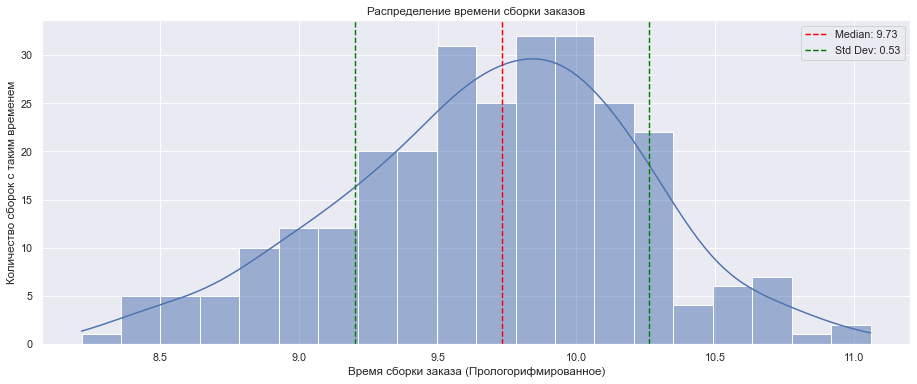

In [160]:
filtered_data = count_df[count_df['full_time_mean'] < 335000]
filtered_data['full_time_mean'] = np.log1p(filtered_data['full_time_mean'])
# Построение гистограммы с оценкой плотности распределения
sns.histplot(data=filtered_data, x = 'full_time_mean', kde=True,bins=20)

# Вычисление медианы и стандартного отклонения
median = filtered_data['full_time_mean'].median()
std_dev = filtered_data['full_time_mean'].std()

# Отрисовка вертикальных линий для медианы и стандартного отклонения
plt.axvline(median, color='red', linestyle='--', label=f'Median: {median:.2f}')
plt.axvline(median + std_dev, color='green', linestyle='--', label=f'Std Dev: {std_dev:.2f}')
plt.axvline(median - std_dev, color='green', linestyle='--')

plt.title('Распределение времени сборки заказов')
plt.xlabel('Время сборки заказа (Прологорифмированное)')
plt.ylabel('Количество сборок с таким временем')
plt.legend()
plt.show()


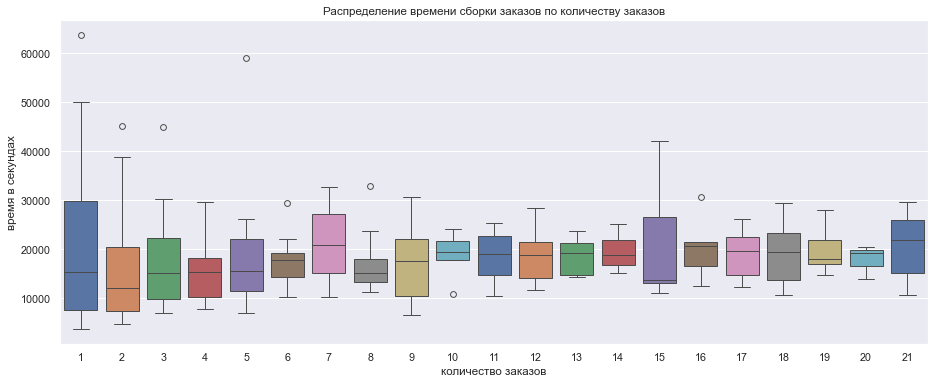

In [161]:
sns.boxplot(data=count_df[count_df['count_order_id'] < 22], 
             y='full_time_mean', x='count_order_id', 
             hue='count_order_id',palette="deep",legend=False)
plt.title('Распределение времени сборки заказов по количеству заказов')
plt.xlabel('количество заказов')
plt.ylabel('время в секундах');

In [162]:
from scipy.stats import f_oneway

# Группируем данные по складам и получаем время сборки заказов для каждого склада
warehouse_groups = count_df[count_df['count_order_id'] < 22].groupby('place')['full_time_mean'].apply(list)

# Проводим тест ANOVA
f_statistic, p_value = f_oneway(*warehouse_groups)

# Печатаем результаты
print(f'F-статистика: {f_statistic}')
print(f'p-значение: {p_value}')

F-статистика: 0.7581165357696974
p-значение: 0.823651297435895


#### Вывод:
- Выбираем нулевую гипотезу, p-value больше 0.05
- Подтверждение тому график, на графике boxplot видно что нету разницы в количестве заказов, средние держутся в диапазоне 10000-20000

### 5. Сегментировать города по произвольному кол-ву количественных признаков: обосновать логику сегментации и предложить модели работы с каждым сегментом.

будем работать:
- с таблицей mean_df 
- признаками 'assembly_start_delay_mean','assembly_duration_mean' чтобы понять как различаются города по времени сборки. 
- избавимся от выбросов

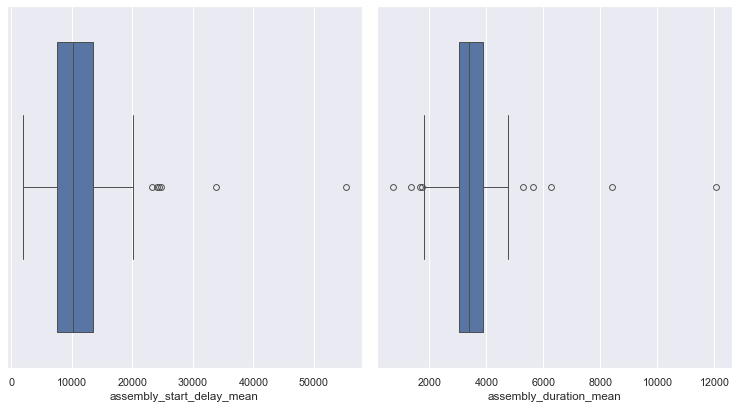

In [163]:
for i, col in enumerate(mean_df[['assembly_start_delay_mean','assembly_duration_mean']], start=1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=mean_df, x = col)
plt.tight_layout()
plt.show()

убираем выбросы

In [164]:
mean_df.loc[mean_df['assembly_start_delay_mean'] > 20000, 'assembly_start_delay_mean'] = mean_df[mean_df['assembly_start_delay_mean'] < 20000]['assembly_start_delay_mean'].quantile(0.95)
mean_df.loc[mean_df['assembly_duration_mean']    >  5000, 'assembly_duration_mean']    = mean_df[mean_df['assembly_duration_mean']    <  5000]['assembly_duration_mean'].quantile(0.95)

строим модель kmeans пока только для обзора методов

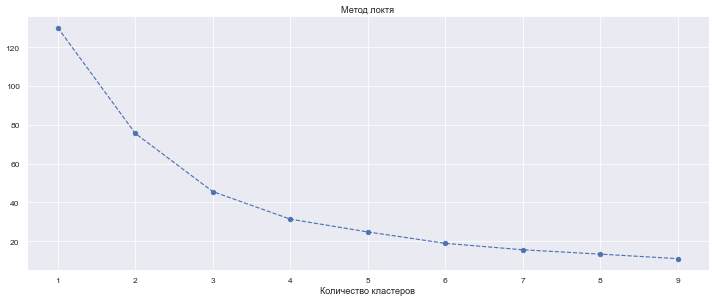

In [165]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Выборка признаков для кластеризации
features =  ['assembly_start_delay_mean','assembly_duration_mean']
X = mean_df[features]

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Поиск оптимального числа кластеров (метод локтя)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Визуализация метода локтя
plt.figure(dpi=55)
plt.plot(range(1, 10), inertia, marker='o', linestyle='--')
plt.xlabel('Количество кластеров')
plt.title('Метод локтя')
plt.show()


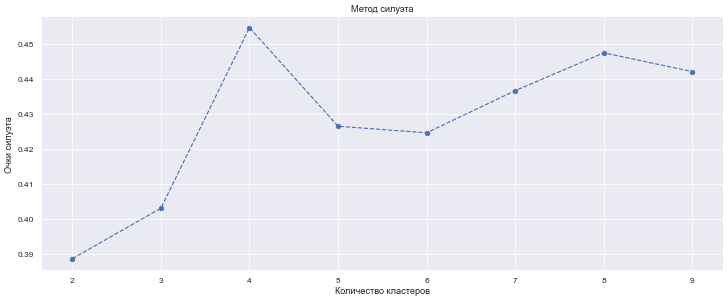

In [166]:
# Определение оптимального числа кластеров через метод силуэта
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Визуализация метода силуэта
plt.figure(dpi=55)
plt.plot(range(2, 10), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Количество кластеров')
plt.ylabel('Очки силуэта')
plt.title('Метод силуэта')
plt.show()

#### метод силуэта подсказал нам брать значение 3 для кластеризации

In [167]:
# Создание объекта KMeans с 4 кластерами и обучение модели
kmeans = KMeans(n_clusters=3, n_init=10, init='k-means++', random_state=42)
mean_df['label'] = kmeans.fit_predict(mean_df[features])

#### Смотрим на результат

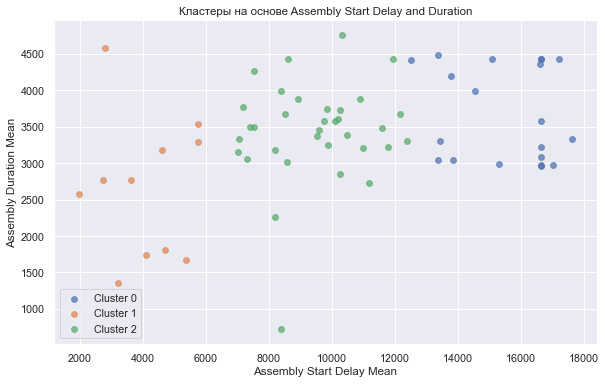

In [168]:
# Разделение данных на основе меток кластеров
cluster_0 = mean_df[mean_df['label'] == 0]
cluster_1 = mean_df[mean_df['label'] == 1]
cluster_2 = mean_df[mean_df['label'] == 2]

plt.figure(figsize=(10, 6))

# Визуализация каждого кластера на плоскости по двум выбранным признакам
plt.scatter(cluster_0['assembly_start_delay_mean'], cluster_0['assembly_duration_mean'], label='Cluster 0', alpha=0.7)
plt.scatter(cluster_1['assembly_start_delay_mean'], cluster_1['assembly_duration_mean'], label='Cluster 1', alpha=0.7)
plt.scatter(cluster_2['assembly_start_delay_mean'], cluster_2['assembly_duration_mean'], label='Cluster 2', alpha=0.7)

plt.xlabel('Assembly Start Delay Mean')
plt.ylabel('Assembly Duration Mean')
plt.title('Кластеры на основе Assembly Start Delay and Duration')
plt.legend()
plt.show()


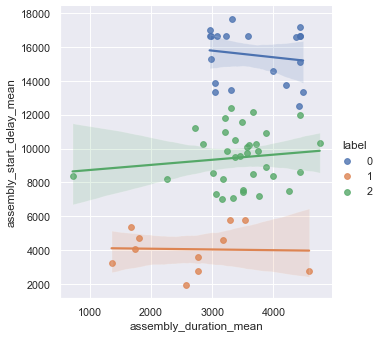

In [169]:
sns.lmplot(y='assembly_start_delay_mean', x='assembly_duration_mean', data=mean_df, hue='label')

#### Итог:
- Разделение на 3 кластера, является приемлемым значением, где можно увидеть разницу в группах:
    - В 0 группе, где сбор заказа является самым медленным, значения разбросаны и визуально разделены на две группы assembly_duration(3000 и 4000)
    - в 1 группе, серидина на значении 10000, у точек есть центр, все расположены близко, есть выбросы по признаку assembly_duration
    - в 2 группе, самые быстрый сбор заказа по двум признакам, самое меньшее количество точек

#### Рекомендация: Нужно работать с нулевой группой, чтобы улучшить показатели, она отстает от всех по двум временым рядам. есть некий центр в 1 группе 10000, считаю что это среднее значение, стремиться к этому результату либо превзойти.

In [170]:
mean_df[mean_df['label'] == 0].sort_values(by='assembly_start_delay_mean',ascending=False).head(10)

,city_name_ru,assembly_duration_mean,assembly_start_delay_mean,full_time_mean,count_order_id,AFF_delay,AFF_duration,AFF_full_time,assembly_start_delay_q,assembly_duration_q,full_time_q,quanitle_rate,label
57,Ходжейли,3326.0,17628.0,20954,15,1.495587,0.918290,1.359887,third,second,third,third_second_third,0
11,Галаасия,4432.0,17211.0,21643,5,1.460208,1.223650,1.404602,third,third,third,third_third_third,0
16,Джалакудук,2971.0,17010.0,19981,2,1.443154,0.820276,1.296741,third,first,third,third_first_third,0
1,Алмазар,4434.7,16658.1,30288,3,2.092362,1.553307,1.965652,third,third,third,third_third_third,0
44,Пскент,4434.7,16658.1,63694,1,4.690379,2.321678,4.133658,third,third,third,third_third_third,0
55,Хива,2979.0,16658.1,36891,19,2.877146,0.822485,2.394178,third,first,third,third_first_third,0
50,Ургенч,3223.0,16658.1,27613,60,2.069285,0.889852,1.792048,third,second,third,third_second_third,0
47,Ташкент,3581.0,16658.1,23755,1076,1.711593,0.988694,1.541669,third,second,third,third_second_third,0
42,Нукус,3082.0,16658.1,27213,53,2.047311,0.850923,1.766088,third,first,third,third_first_third,0
35,Куксарай,2960.0,16658.1,26286,1,1.979098,0.817239,1.705927,third,first,third,third_first_third,0
